<a href="https://colab.research.google.com/github/shreyas1209/Sudoku_Solver_App/blob/main/Sudoku_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.nn.functional as F
import time 
import random
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torchvision.utils as vutils

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
X = ((X-np.mean(X))/(np.std(X)))
X = X.reshape(X.shape[0],1,28,28)


In [ ]:
X = X.astype('float32')
y = np.int_(y)


In [ ]:
X = torch.tensor(X)
y = torch.tensor(y)
y = y.type(torch.LongTensor)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.33, random_state=42)
print(X_train.dtype)



torch.float32


In [ ]:
train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)

In [ ]:
batchsize = 64
train_dataloader = DataLoader(dataset=train_dataset,batch_size = batchsize)
val_dataloader = DataLoader(dataset=val_dataset,batch_size = batchsize)

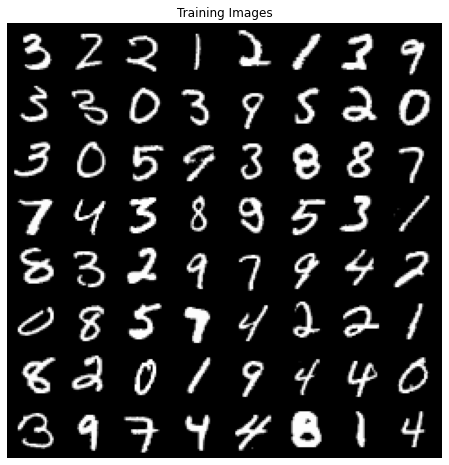

In [ ]:
#plotting the images
train_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0][:64], padding=2, normalize=True),(1,2,0)))


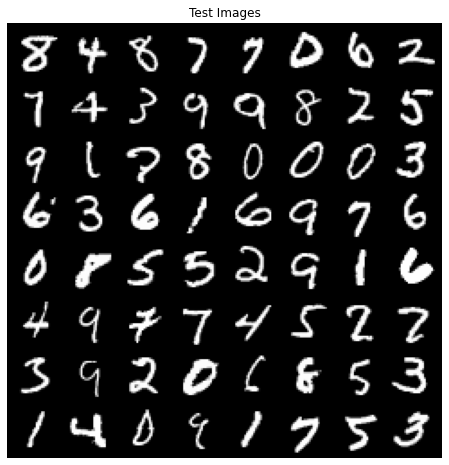

In [ ]:
#plotting a set of  val images
val_batch = next(iter(val_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0][:64], padding=2, normalize=True),(1,2,0)))

In [ ]:
def check_accuracy(model,dataloader):
  num_correct = 0
  num_samples = 0
  model.eval()
  model = model.to(device)
  
  with torch.no_grad():
    for DATA  in dataloader:
      data = DATA[0]
      data = data.to(device)
      classes = DATA[1]
      classes = classes.to(device)
      scores = model(data)
      predictions = scores.argmax(1)
      num_correct += sum((predictions == classes))
      num_samples += predictions.size(0)

    return float(num_correct)/float(num_samples)


In [ ]:
def train (model,loss_function,optimizer,train_dl,val_dl,epochs):
  if torch.cuda.is_available(): torch.cuda.empty_cache()
  model = model.to(device = device)
  history = {"train_accuracies": [], "val_accuracies": [], "loss":[]}

  for epoch in range (epochs):
    
    model.train()
    train_loss = 0
    start = time.time()

    for batch_no,DATA in enumerate(train_dl,0):
      data,classes = DATA
      optimizer.zero_grad()
      data = data.to(torch.float32)
      data = data.to(device)
      classes = classes.to(device)
      outputs = model(data)
      loss = loss_function(outputs,classes)
      loss.backward()
      optimizer.step()

      
      running_loss = loss.item()
    
    #getting the stats
    history['train_accuracies'].append(check_accuracy(model,train_dl))
    history['val_accuracies'].append(check_accuracy(model,val_dl))
    history['loss'].append(running_loss/(len(train_dl)))
    
    end = time.time()
    total_time = end-start

    #printing the stats
    print('Epoch ({}/{}),Training loss : {:.8f}, Time: {:.2f}, train_accuracy:{:.4f}, val_accuracy:{:.4f}'.format(
          epoch+1, epochs, history["loss"][-1], total_time, history["train_accuracies"][-1], history["val_accuracies"][-1]))

  return model, history

In [ ]:
#importing the model

import sys

sys.path.append('/content/gdrive/MyDrive/Sudoku/Models')

In [ ]:
from sudoku_net import *

In [ ]:
def plot_analysis(history,epochs):
  epoch_no = [(i+1) for i in range(epochs)]

  plt.plot(epoch_no,history["train_accuracies"], label = 'Train Accuracies')
  plt.plot(epoch_no,history["val_accuracies"], label = 'Validation Accuracies')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracies")
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epoch_no,history["loss"])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Loss')
  plt.show()


In [ ]:
epochs = 15
learning_rate = 1e-3

In [ ]:
model1  = sudokunet1(output_classes=10)
model2 = sudokunet2(output_classes=10)
model3 = sudokunet3(output_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr = learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr = learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr = learning_rate)


In [ ]:
start = time.time()
model1,history1 = train(model = model1,
                      loss_function=loss_fn,
                      optimizer = optimizer1,
                      train_dl = train_dataloader,
                      val_dl = val_dataloader,
                      epochs = epochs)
end = time.time()
elapsed = end-start
print("Total time :", elapsed)

/content/gdrive/MyDrive/Sudoku/Models/sudoku_net.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch (1/15),Training loss : 0.00205627, Time: 5.47, train_accuracy:0.9679, val_accuracy:0.9648
Epoch (2/15),Training loss : 0.00206992, Time: 5.28, train_accuracy:0.9748, val_accuracy:0.9732
Epoch (3/15),Training loss : 0.00205100, Time: 5.29, train_accuracy:0.9772, val_accuracy:0.9744
Epoch (4/15),Training loss : 0.00204971, Time: 5.29, train_accuracy:0.9832, val_accuracy:0.9794
Epoch (5/15),Training loss : 0.00206744, Time: 5.25, train_accuracy:0.9848, val_accuracy:0.9814
Epoch (6/15),Training loss : 0.00206690, Time: 5.22, train_accuracy:0.9873, val_accuracy:0.9836
Epoch (7/15),Training loss : 0.00199388, Time: 5.25, train_accuracy:0.9859, val_accuracy:0.9823
Epoch (8/15),Training loss : 0.00207204, Time: 5.25, train_accuracy:0.9886, val_accuracy:0.9852
Epoch (9/15),Training loss : 0.00203929, Time: 5.31, train_accuracy:0.9858, val_accuracy:0.9824
Epoch (10/15),Training loss : 0.00201963, Time: 5.27, train_accuracy:0.9880, val_accuracy:0.9843
Epoch (11/15),Training loss : 0.0020196

In [ ]:
start = time.time()
model2,history2 = train(model = model2,
                      loss_function=loss_fn,
                      optimizer = optimizer2,
                      train_dl = train_dataloader,
                      val_dl = val_dataloader,
                      epochs = epochs)
end = time.time()
elapsed = end-start
print("Total time :", elapsed)

/content/gdrive/MyDrive/Sudoku/Models/sudoku_net.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch (1/15),Training loss : 0.00209740, Time: 5.83, train_accuracy:0.9586, val_accuracy:0.9582
Epoch (2/15),Training loss : 0.00202029, Time: 5.83, train_accuracy:0.9733, val_accuracy:0.9690
Epoch (3/15),Training loss : 0.00208986, Time: 5.82, train_accuracy:0.9737, val_accuracy:0.9708
Epoch (4/15),Training loss : 0.00204627, Time: 5.84, train_accuracy:0.9781, val_accuracy:0.9741
Epoch (5/15),Training loss : 0.00205610, Time: 5.84, train_accuracy:0.9804, val_accuracy:0.9754
Epoch (6/15),Training loss : 0.00204546, Time: 5.83, train_accuracy:0.9831, val_accuracy:0.9791
Epoch (7/15),Training loss : 0.00207116, Time: 5.84, train_accuracy:0.9814, val_accuracy:0.9775
Epoch (8/15),Training loss : 0.00199344, Time: 5.75, train_accuracy:0.9838, val_accuracy:0.9788
Epoch (9/15),Training loss : 0.00201833, Time: 5.80, train_accuracy:0.9838, val_accuracy:0.9790
Epoch (10/15),Training loss : 0.00204530, Time: 5.81, train_accuracy:0.9851, val_accuracy:0.9802
Epoch (11/15),Training loss : 0.0020197

In [ ]:
start = time.time()
model3,history3 = train(model = model3,
                      loss_function=loss_fn,
                      optimizer = optimizer3,
                      train_dl = train_dataloader,
                      val_dl = val_dataloader,
                      epochs = epochs)
end = time.time()
elapsed = end-start
print("Total time :", elapsed)

/content/gdrive/MyDrive/Sudoku/Models/sudoku_net.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch (1/15),Training loss : 0.00205391, Time: 5.67, train_accuracy:0.9673, val_accuracy:0.9656
Epoch (2/15),Training loss : 0.00206701, Time: 5.58, train_accuracy:0.9786, val_accuracy:0.9750
Epoch (3/15),Training loss : 0.00205388, Time: 5.66, train_accuracy:0.9837, val_accuracy:0.9815
Epoch (4/15),Training loss : 0.00201924, Time: 5.67, train_accuracy:0.9831, val_accuracy:0.9800
Epoch (5/15),Training loss : 0.00200167, Time: 5.61, train_accuracy:0.9852, val_accuracy:0.9819
Epoch (6/15),Training loss : 0.00205111, Time: 5.62, train_accuracy:0.9858, val_accuracy:0.9821
Epoch (7/15),Training loss : 0.00199341, Time: 5.66, train_accuracy:0.9890, val_accuracy:0.9862
Epoch (8/15),Training loss : 0.00199339, Time: 5.62, train_accuracy:0.9881, val_accuracy:0.9845
Epoch (9/15),Training loss : 0.00199338, Time: 5.63, train_accuracy:0.9913, val_accuracy:0.9872
Epoch (10/15),Training loss : 0.00205186, Time: 5.65, train_accuracy:0.9905, val_accuracy:0.9870
Epoch (11/15),Training loss : 0.0019933

In [ ]:
torch.save(model1.state_dict(), 'sudokunet_model1_weights.pth')
torch.save(model2.state_dict(), 'sudokunet_model2_weights.pth')
torch.save(model3.state_dict(), 'sudokunet_model3_weights.pth')

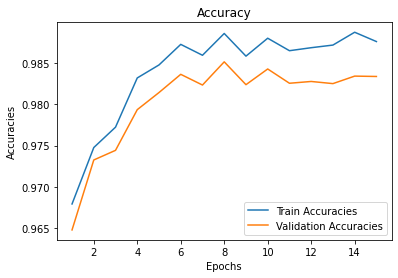

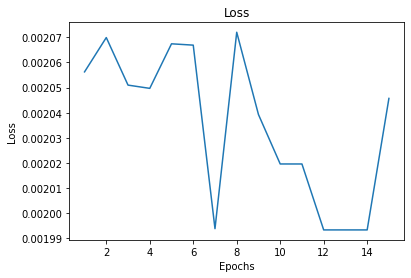

In [ ]:
plot_analysis(history1,epochs)

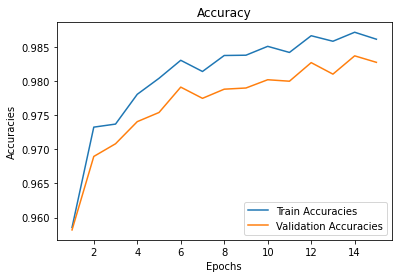

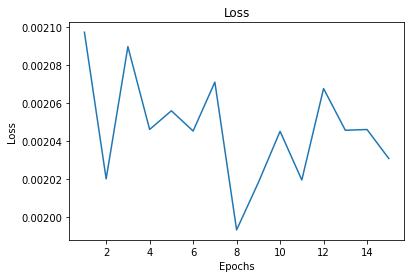

In [ ]:
plot_analysis(history2,epochs)

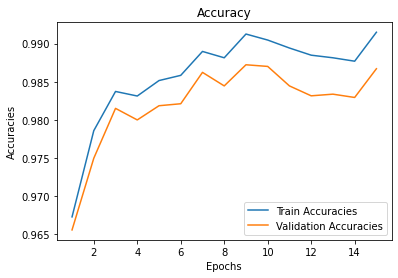

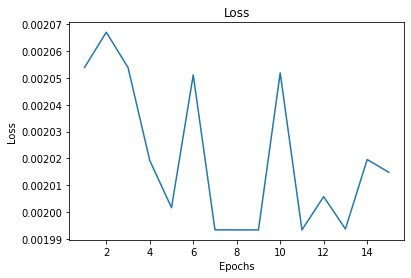

In [ ]:
plot_analysis(history3,epochs)